# Jump Diffusion Model

## Introduction

The **Jump Diffusion Model**, introduced by Robert C. Merton in 1976, extends the classical Black-Scholes geometric Brownian motion framework by incorporating discontinuous jumps in asset prices. This modification addresses the empirical observation that financial markets exhibit sudden, significant price movements that cannot be captured by continuous diffusion processes alone.

## Theoretical Foundation

### Standard Geometric Brownian Motion

The classical Black-Scholes model assumes asset prices follow:

$$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t$$

where:
- $S_t$ is the asset price at time $t$
- $\mu$ is the drift rate
- $\sigma$ is the volatility
- $W_t$ is a standard Wiener process

### Merton's Jump Diffusion Extension

Merton's model augments this with a compound Poisson jump process:

$$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t + S_{t^-} \, dJ_t$$

where $J_t$ is a compound Poisson process defined as:

$$J_t = \sum_{i=1}^{N_t} (Y_i - 1)$$

Here:
- $N_t$ is a Poisson process with intensity $\lambda$ (average number of jumps per unit time)
- $Y_i$ are i.i.d. random variables representing the jump multipliers
- $S_{t^-}$ denotes the price immediately before a jump

### Log-Normal Jump Distribution

Typically, $\ln(Y_i) \sim \mathcal{N}(\mu_J, \sigma_J^2)$, giving:

$$\mathbb{E}[Y_i] = e^{\mu_J + \frac{1}{2}\sigma_J^2}$$

### Solution to the SDE

The solution to Merton's jump diffusion SDE is:

$$S_t = S_0 \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right] \prod_{i=1}^{N_t} Y_i$$

In logarithmic form:

$$\ln\left(\frac{S_t}{S_0}\right) = \left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t + \sum_{i=1}^{N_t} \ln(Y_i)$$

### Risk-Neutral Dynamics

Under the risk-neutral measure, the drift is adjusted to ensure the discounted price process is a martingale:

$$\mu^* = r - \lambda \kappa$$

where:
- $r$ is the risk-free rate
- $\kappa = \mathbb{E}[Y - 1] = e^{\mu_J + \frac{1}{2}\sigma_J^2} - 1$ is the expected relative jump size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Model parameters
S0 = 100.0          # Initial asset price
mu = 0.1            # Drift rate (annual)
sigma = 0.2         # Volatility (annual)
lambda_j = 0.75     # Jump intensity (expected jumps per year)
mu_j = -0.05        # Mean of log-jump size
sigma_j = 0.1       # Std dev of log-jump size
T = 1.0             # Time horizon (years)
n_steps = 252       # Number of time steps (daily)
n_paths = 1000      # Number of simulation paths

dt = T / n_steps    # Time step size
t = np.linspace(0, T, n_steps + 1)

print("Jump Diffusion Model Parameters:")
print(f"Initial Price S₀ = {S0}")
print(f"Drift μ = {mu}")
print(f"Volatility σ = {sigma}")
print(f"Jump Intensity λ = {lambda_j}")
print(f"Jump Mean μⱼ = {mu_j}")
print(f"Jump Vol σⱼ = {sigma_j}")
print(f"Time Horizon T = {T} years")
print(f"Time Steps = {n_steps}")

Jump Diffusion Model Parameters:
Initial Price S₀ = 100.0
Drift μ = 0.1
Volatility σ = 0.2
Jump Intensity λ = 0.75
Jump Mean μⱼ = -0.05
Jump Vol σⱼ = 0.1
Time Horizon T = 1.0 years
Time Steps = 252


## Monte Carlo Simulation

We simulate the jump diffusion process using a discretized Euler-Maruyama scheme with superimposed Poisson jumps:

$$S_{t+\Delta t} = S_t \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)\Delta t + \sigma\sqrt{\Delta t}\, Z + \sum_{i=1}^{N_{\Delta t}} J_i\right]$$

where $Z \sim \mathcal{N}(0,1)$, $N_{\Delta t} \sim \text{Poisson}(\lambda \Delta t)$, and $J_i \sim \mathcal{N}(\mu_J, \sigma_J^2)$.

In [2]:
def simulate_jump_diffusion(S0, mu, sigma, lambda_j, mu_j, sigma_j, T, n_steps, n_paths):
    """
    Simulate Merton's Jump Diffusion Model using Monte Carlo.
    
    Parameters:
    -----------
    S0 : float - Initial asset price
    mu : float - Drift rate
    sigma : float - Diffusion volatility
    lambda_j : float - Jump intensity
    mu_j : float - Mean of log-jump size
    sigma_j : float - Std of log-jump size
    T : float - Time horizon
    n_steps : int - Number of time steps
    n_paths : int - Number of simulation paths
    
    Returns:
    --------
    S : ndarray - Simulated price paths (n_paths x n_steps+1)
    """
    dt = T / n_steps
    
    # Initialize price matrix
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    
    # Precompute constants
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    for i in range(n_steps):
        # Brownian motion component
        Z = np.random.standard_normal(n_paths)
        
        # Poisson jumps: number of jumps in this time step
        N_jumps = np.random.poisson(lambda_j * dt, n_paths)
        
        # Aggregate jump sizes for each path
        jump_sizes = np.zeros(n_paths)
        for j in range(n_paths):
            if N_jumps[j] > 0:
                # Sum of log-normal jump sizes
                jump_sizes[j] = np.sum(
                    np.random.normal(mu_j, sigma_j, N_jumps[j])
                )
        
        # Update prices
        S[:, i + 1] = S[:, i] * np.exp(drift + diffusion * Z + jump_sizes)
    
    return S

# Run simulation
S_paths = simulate_jump_diffusion(S0, mu, sigma, lambda_j, mu_j, sigma_j, T, n_steps, n_paths)

print(f"Simulation complete: {n_paths} paths generated")
print(f"Final prices - Mean: {np.mean(S_paths[:, -1]):.2f}, Std: {np.std(S_paths[:, -1]):.2f}")

Simulation complete: 1000 paths generated
Final prices - Mean: 106.81, Std: 23.82


## Comparison with Pure Diffusion

To highlight the effect of jumps, we also simulate standard Geometric Brownian Motion (GBM) without jumps.

In [3]:
def simulate_gbm(S0, mu, sigma, T, n_steps, n_paths):
    """
    Simulate standard Geometric Brownian Motion.
    """
    dt = T / n_steps
    
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    for i in range(n_steps):
        Z = np.random.standard_normal(n_paths)
        S[:, i + 1] = S[:, i] * np.exp(drift + diffusion * Z)
    
    return S

# Simulate GBM for comparison
S_gbm = simulate_gbm(S0, mu, sigma, T, n_steps, n_paths)

print(f"GBM Simulation complete")
print(f"Final prices - Mean: {np.mean(S_gbm[:, -1]):.2f}, Std: {np.std(S_gbm[:, -1]):.2f}")

GBM Simulation complete
Final prices - Mean: 109.58, Std: 22.34


## Visualization and Analysis

We visualize sample paths, return distributions, and statistical properties of both models.

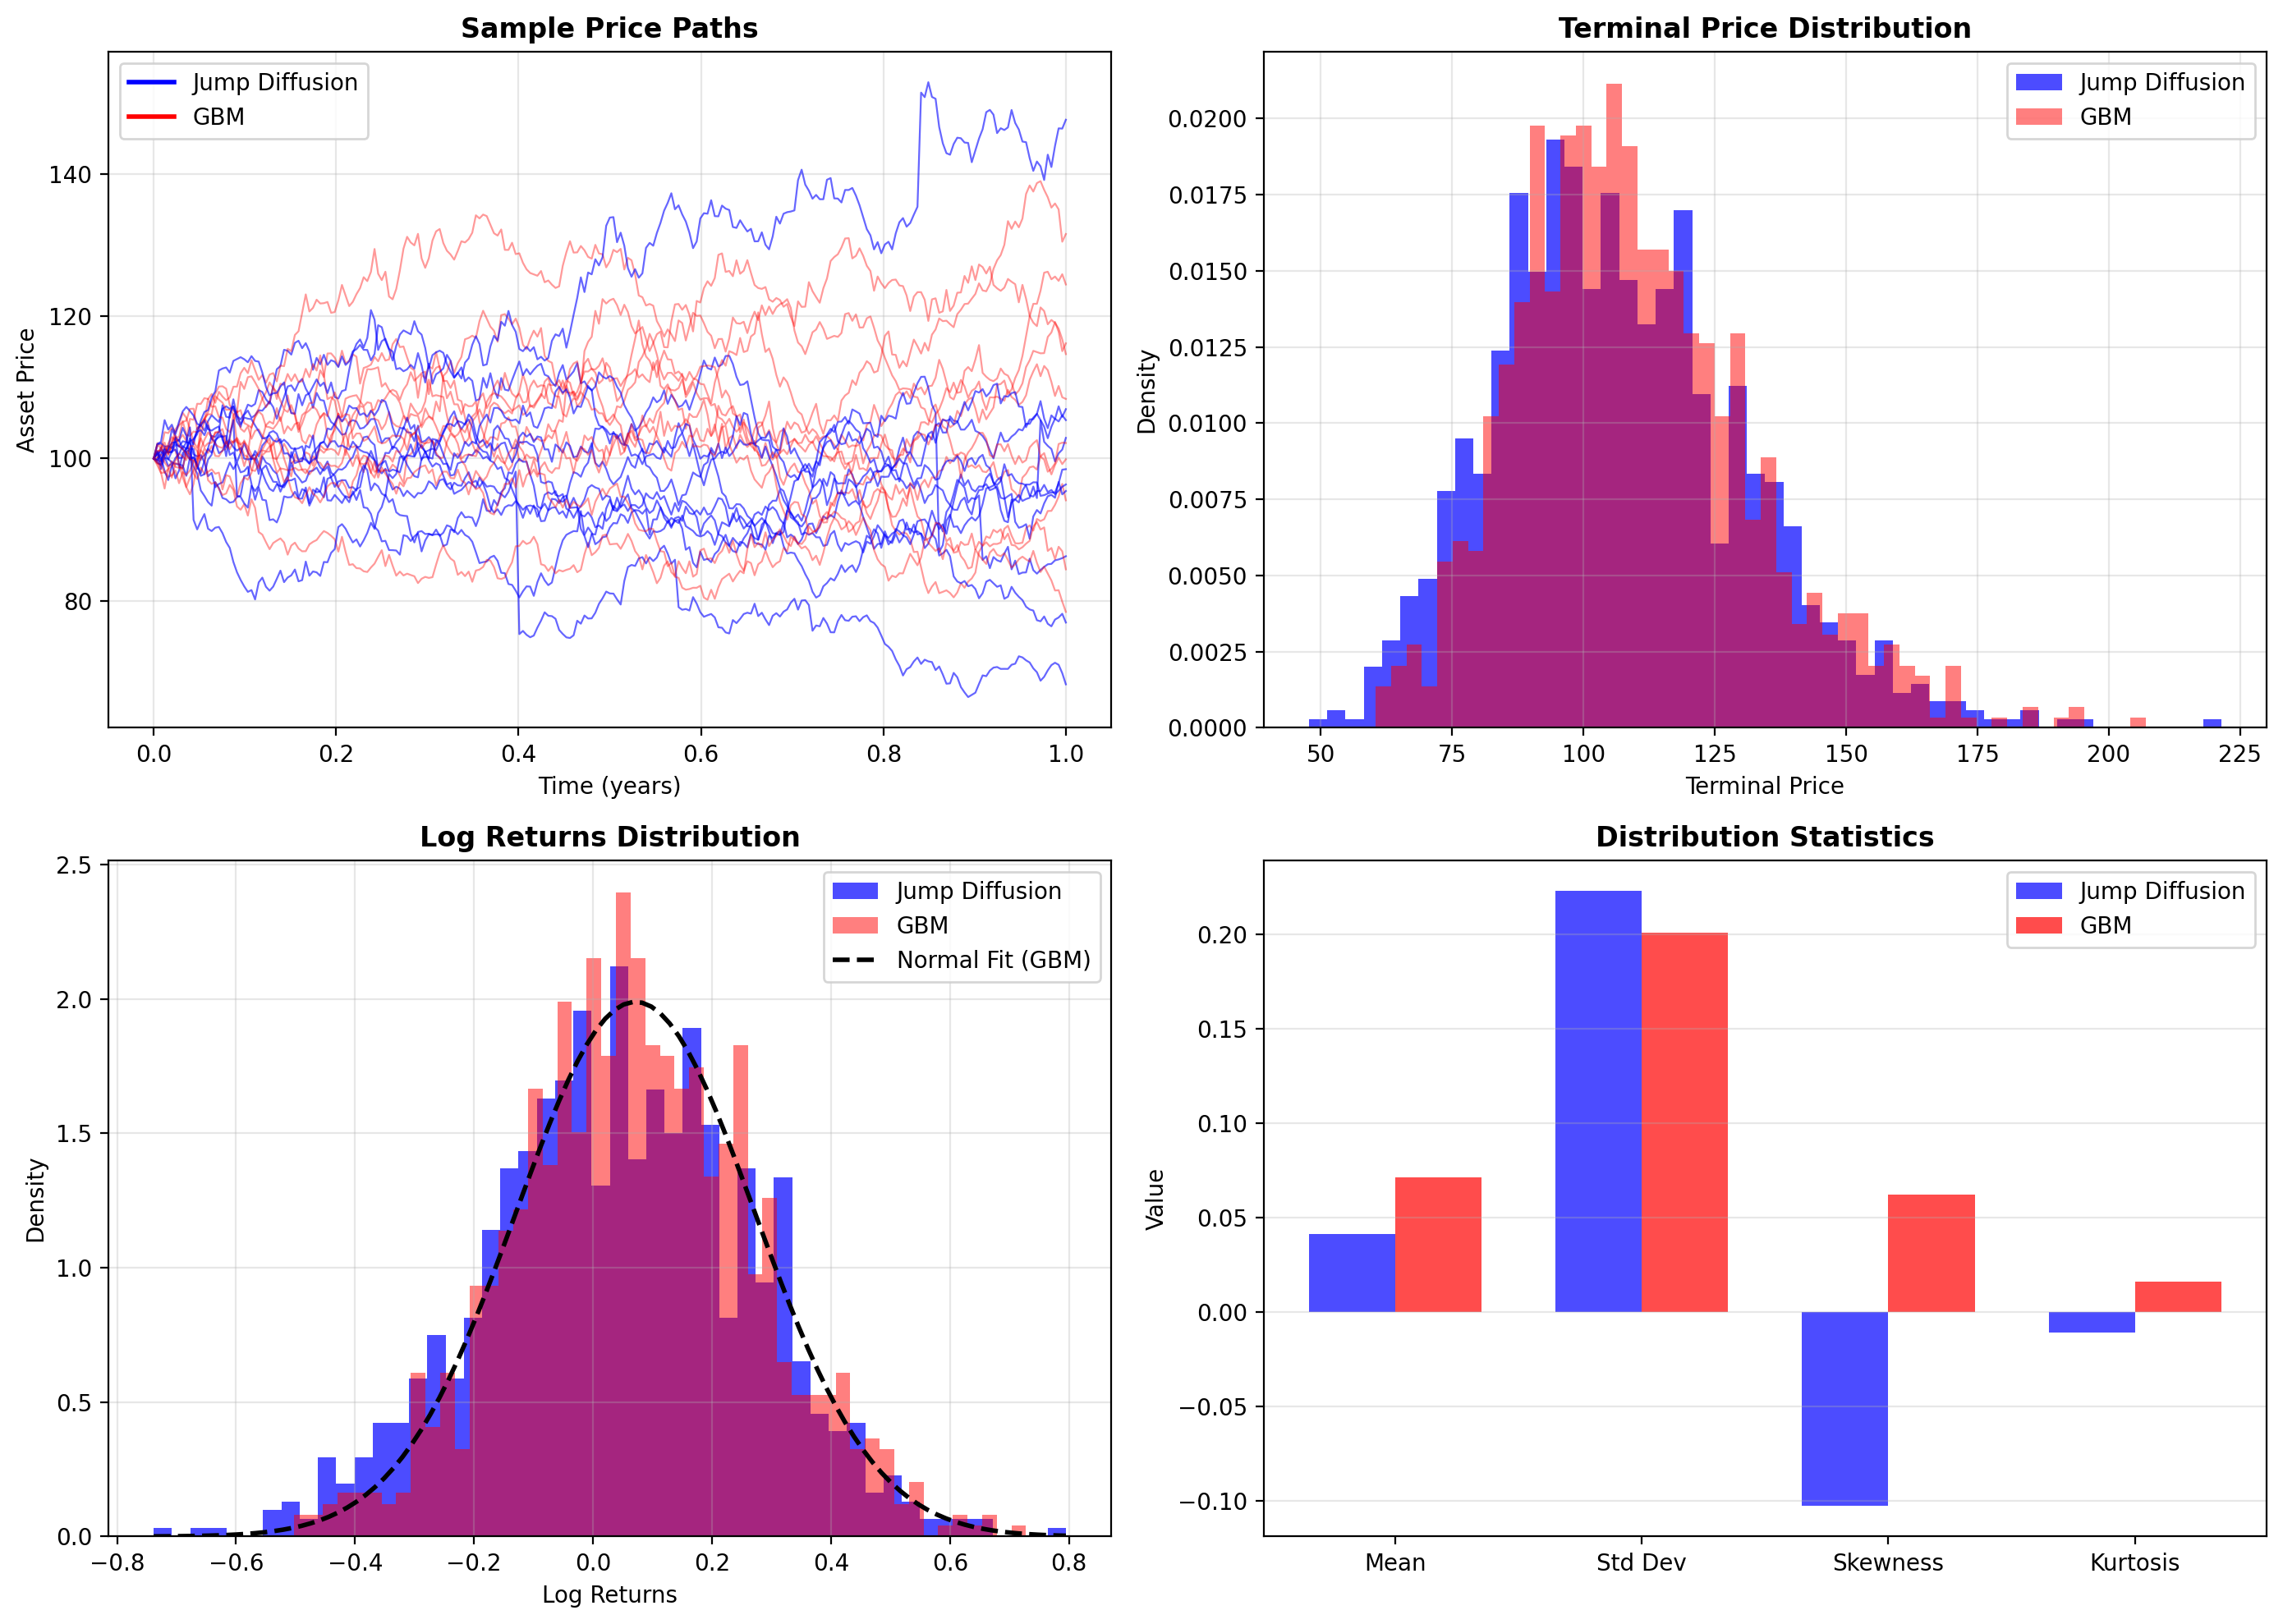


Plot saved to 'plot.png'


In [4]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Sample paths comparison
ax1 = fig.add_subplot(2, 2, 1)
n_sample = 10
for i in range(n_sample):
    ax1.plot(t, S_paths[i, :], 'b-', alpha=0.6, linewidth=0.8)
    ax1.plot(t, S_gbm[i, :], 'r-', alpha=0.4, linewidth=0.8)
ax1.plot([], [], 'b-', label='Jump Diffusion', linewidth=2)
ax1.plot([], [], 'r-', label='GBM', linewidth=2)
ax1.set_xlabel('Time (years)', fontsize=10)
ax1.set_ylabel('Asset Price', fontsize=10)
ax1.set_title('Sample Price Paths', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Terminal distribution
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(S_paths[:, -1], bins=50, density=True, alpha=0.7, color='blue', label='Jump Diffusion')
ax2.hist(S_gbm[:, -1], bins=50, density=True, alpha=0.5, color='red', label='GBM')
ax2.set_xlabel('Terminal Price', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_title('Terminal Price Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Log returns distribution
ax3 = fig.add_subplot(2, 2, 3)
log_returns_jd = np.log(S_paths[:, -1] / S_paths[:, 0])
log_returns_gbm = np.log(S_gbm[:, -1] / S_gbm[:, 0])

ax3.hist(log_returns_jd, bins=50, density=True, alpha=0.7, color='blue', label='Jump Diffusion')
ax3.hist(log_returns_gbm, bins=50, density=True, alpha=0.5, color='red', label='GBM')

# Overlay normal distribution for reference
x_range = np.linspace(min(log_returns_jd.min(), log_returns_gbm.min()),
                      max(log_returns_jd.max(), log_returns_gbm.max()), 100)
normal_pdf = stats.norm.pdf(x_range, np.mean(log_returns_gbm), np.std(log_returns_gbm))
ax3.plot(x_range, normal_pdf, 'k--', linewidth=2, label='Normal Fit (GBM)')

ax3.set_xlabel('Log Returns', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Log Returns Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Statistics comparison
ax4 = fig.add_subplot(2, 2, 4)

# Calculate statistics
stats_labels = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis']
jd_stats = [
    np.mean(log_returns_jd),
    np.std(log_returns_jd),
    stats.skew(log_returns_jd),
    stats.kurtosis(log_returns_jd)
]
gbm_stats = [
    np.mean(log_returns_gbm),
    np.std(log_returns_gbm),
    stats.skew(log_returns_gbm),
    stats.kurtosis(log_returns_gbm)
]

x_pos = np.arange(len(stats_labels))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, jd_stats, width, label='Jump Diffusion', color='blue', alpha=0.7)
bars2 = ax4.bar(x_pos + width/2, gbm_stats, width, label='GBM', color='red', alpha=0.7)

ax4.set_ylabel('Value', fontsize=10)
ax4.set_title('Distribution Statistics', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(stats_labels)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save the plot
plt.savefig('jump_diffusion_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Statistical Analysis

Let's examine the key differences between Jump Diffusion and pure GBM.

In [5]:
# Detailed statistical comparison
print("="*60)
print("STATISTICAL COMPARISON: Jump Diffusion vs. GBM")
print("="*60)

print("\nLog Returns Statistics:")
print("-"*40)
print(f"{'Statistic':<20} {'Jump Diff':>12} {'GBM':>12}")
print("-"*40)
print(f"{'Mean':<20} {np.mean(log_returns_jd):>12.4f} {np.mean(log_returns_gbm):>12.4f}")
print(f"{'Std Deviation':<20} {np.std(log_returns_jd):>12.4f} {np.std(log_returns_gbm):>12.4f}")
print(f"{'Skewness':<20} {stats.skew(log_returns_jd):>12.4f} {stats.skew(log_returns_gbm):>12.4f}")
print(f"{'Kurtosis':<20} {stats.kurtosis(log_returns_jd):>12.4f} {stats.kurtosis(log_returns_gbm):>12.4f}")
print(f"{'5th Percentile':<20} {np.percentile(log_returns_jd, 5):>12.4f} {np.percentile(log_returns_gbm, 5):>12.4f}")
print(f"{'95th Percentile':<20} {np.percentile(log_returns_jd, 95):>12.4f} {np.percentile(log_returns_gbm, 95):>12.4f}")

print("\n" + "="*60)
print("KEY OBSERVATIONS:")
print("="*60)
print("\n1. Higher kurtosis in Jump Diffusion indicates fat tails")
print("2. Negative skewness reflects downward jump bias (μⱼ < 0)")
print("3. Jump Diffusion better captures extreme market movements")
print("4. GBM underestimates tail risk in financial applications")

STATISTICAL COMPARISON: Jump Diffusion vs. GBM

Log Returns Statistics:
----------------------------------------
Statistic               Jump Diff          GBM
----------------------------------------
Mean                       0.0412       0.0713
Std Deviation              0.2229       0.2006
Skewness                  -0.1025       0.0622
Kurtosis                  -0.0110       0.0163
5th Percentile            -0.3376      -0.2588
95th Percentile            0.3907       0.4160

KEY OBSERVATIONS:

1. Higher kurtosis in Jump Diffusion indicates fat tails
2. Negative skewness reflects downward jump bias (μⱼ < 0)
3. Jump Diffusion better captures extreme market movements
4. GBM underestimates tail risk in financial applications


## Theoretical Expected Values

Under the Merton model, the expected asset price at time $T$ is:

$$\mathbb{E}[S_T] = S_0 \exp\left[(\mu + \lambda\kappa)T\right]$$

where $\kappa = e^{\mu_J + \frac{1}{2}\sigma_J^2} - 1$.

In [6]:
# Theoretical vs simulated comparison
kappa = np.exp(mu_j + 0.5 * sigma_j**2) - 1
expected_ST_jd = S0 * np.exp((mu + lambda_j * kappa) * T)
expected_ST_gbm = S0 * np.exp(mu * T)

print("\nTheoretical vs Simulated Expected Terminal Price:")
print("-"*50)
print(f"{'Model':<20} {'Theoretical':>15} {'Simulated':>15}")
print("-"*50)
print(f"{'Jump Diffusion':<20} {expected_ST_jd:>15.2f} {np.mean(S_paths[:, -1]):>15.2f}")
print(f"{'GBM':<20} {expected_ST_gbm:>15.2f} {np.mean(S_gbm[:, -1]):>15.2f}")
print(f"\nExpected jump contribution κ = {kappa:.4f}")
print(f"With negative μⱼ, jumps reduce expected price growth")


Theoretical vs Simulated Expected Terminal Price:
--------------------------------------------------
Model                    Theoretical       Simulated
--------------------------------------------------
Jump Diffusion                106.93          106.81
GBM                           110.52          109.58

Expected jump contribution κ = -0.0440
With negative μⱼ, jumps reduce expected price growth


## Conclusion

The Merton Jump Diffusion Model provides a more realistic representation of asset price dynamics by incorporating:

1. **Fat tails**: Higher kurtosis captures extreme events better than GBM
2. **Asymmetry**: Skewness allows modeling of directional jump bias
3. **Discontinuities**: Sudden price jumps reflect market crashes and rallies

### Applications

- **Option pricing**: More accurate for out-of-the-money options
- **Risk management**: Better VaR and CVaR estimates
- **Portfolio optimization**: Accounts for jump risk

### Limitations

- Jump parameters are difficult to calibrate from historical data
- Market incompleteness due to jump risk
- Assumes constant jump intensity and distribution parameters